# ADASYN (Adaptive Synthetic Sampling) pada dataset yang tidak seimbang (imbalanced)

## 1. Membuat Dataset Tidak Seimbang

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
import numpy as np

# Memuat dataset Iris
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

# Mengubah menjadi DataFrame untuk kemudahan manipulasi
df = pd.DataFrame(data=np.c_[X, y], columns=iris.feature_names + ['target'])
df['species'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Mengambil semua data untuk kelas versicolor (50) dan virginica (50)
df_versicolor = df[df['species'] == 'versicolor']
df_virginica = df[df['species'] == 'virginica']

# Mengambil hanya 15 data untuk kelas setosa
df_setosa = df[df['species'] == 'setosa'].sample(15, random_state=42)

# Menggabungkan kembali untuk membuat dataset tidak seimbang
df_imbalanced = pd.concat([df_setosa, df_versicolor, df_virginica])

# Memisahkan fitur (X) dan target (y)
X_imbalanced = df_imbalanced[iris.feature_names].values
y_imbalanced = df_imbalanced['target'].astype('int').values

# Menampilkan distribusi kelas yang baru
print("Distribusi kelas setelah dibuat tidak seimbang:")
print(pd.Series(y_imbalanced).value_counts())

Distribusi kelas setelah dibuat tidak seimbang:
1    50
2    50
0    15
Name: count, dtype: int64


## 2. Visualisasi PCA 2D (Sebelum Oversampling)

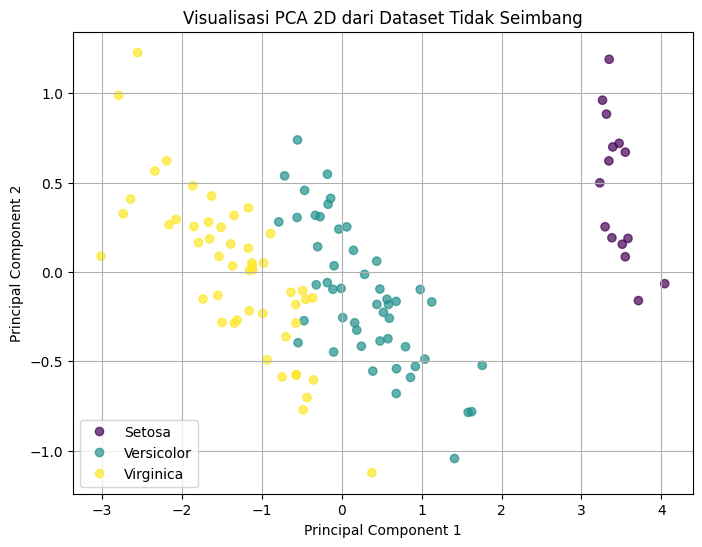

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Inisialisasi PCA dengan 2 komponen
pca = PCA(n_components=2)
X_pca_imbalanced = pca.fit_transform(X_imbalanced)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_imbalanced[:, 0], X_pca_imbalanced[:, 1], c=y_imbalanced, cmap='viridis', alpha=0.7)
plt.title('Visualisasi PCA 2D dari Dataset Tidak Seimbang')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Setosa', 'Versicolor', 'Virginica'])
plt.grid(True)
plt.show()

## 3. Oversampling dengan ADASYN

In [4]:
# Ganti baris import ADASYN
# from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE # <-- Ganti dengan ini

# Ganti inisialisasi ADASYN
# adasyn = ADASYN(random_state=42)
smote = SMOTE(random_state=42) # <-- Ganti dengan ini

# Melakukan oversampling pada data menggunakan SMOTE
X_resampled, y_resampled = smote.fit_resample(X_imbalanced, y_imbalanced)

# Menampilkan distribusi kelas setelah SMOTE
print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_resampled).value_counts())


Distribusi kelas setelah SMOTE:
0    50
1    50
2    50
Name: count, dtype: int64


## 4. Proses Klasifikasi dan Evaluasi


--- Laporan Klasifikasi pada Dataset TIDAK SEIMBANG ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         5
  versicolor       1.00      1.00      1.00        15
   virginica       1.00      1.00      1.00        15

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35


--- Laporan Klasifikasi pada Dataset SEIMBANG (ADASYN) ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      1.00      1.00        15
   virginica       1.00      1.00      1.00        15

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



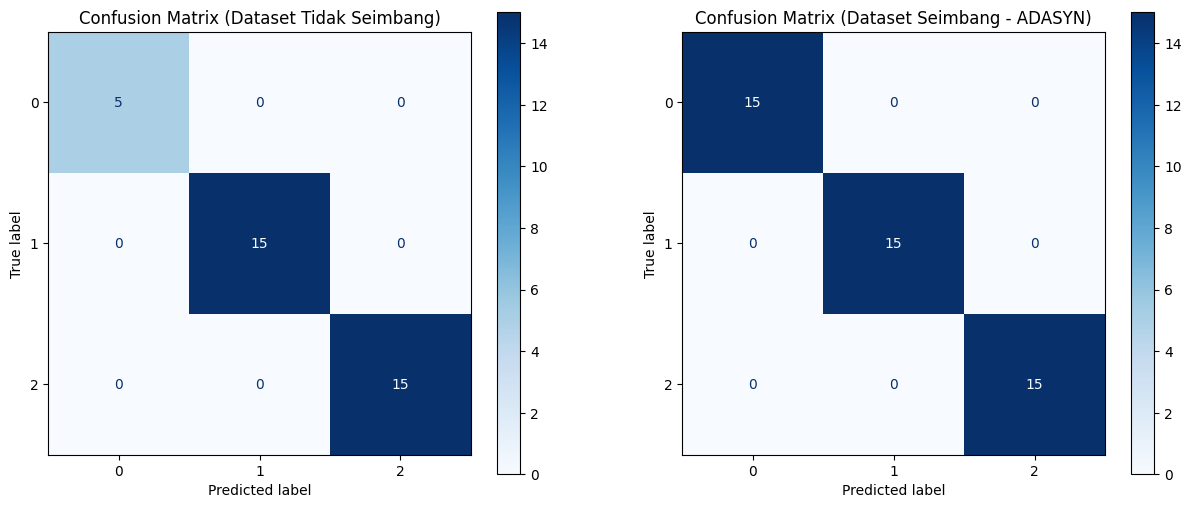

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# ---- 1. Klasifikasi pada Dataset TIDAK SEIMBANG ----
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imbalanced, y_imbalanced, test_size=0.3, random_state=42, stratify=y_imbalanced)

model_imb = SVC(kernel='linear', probability=True, random_state=42)
model_imb.fit(X_train_imb, y_train_imb)
y_pred_imb = model_imb.predict(X_test_imb)

print("\n--- Laporan Klasifikasi pada Dataset TIDAK SEIMBANG ---")
print(classification_report(y_test_imb, y_pred_imb, target_names=target_names))

# ---- 2. Klasifikasi pada Dataset SEIMBANG (Hasil ADASYN) ----
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

model_res = SVC(kernel='linear', probability=True, random_state=42)
model_res.fit(X_train_res, y_train_res)
y_pred_res = model_res.predict(X_test_res)

print("\n--- Laporan Klasifikasi pada Dataset SEIMBANG (ADASYN) ---")
print(classification_report(y_test_res, y_pred_res, target_names=target_names))

# Menampilkan Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Confusion Matrix (Dataset Tidak Seimbang)')
ConfusionMatrixDisplay.from_estimator(model_imb, X_test_imb, y_test_imb, ax=axes[0], cmap='Blues')
axes[1].set_title('Confusion Matrix (Dataset Seimbang - ADASYN)')
ConfusionMatrixDisplay.from_estimator(model_res, X_test_res, y_test_res, ax=axes[1], cmap='Blues')
plt.show()